In [1]:
from datetime import datetime
import os
import sys
import urllib.request
import pandas as pd 
import json
import re 
import requests
import simplejson
import numpy as np
import random
from konlpy.tag import Okt
from collections import Counter
import json
from itertools import product, starmap
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

In [2]:
Naver_client_id = "pjDoY3hgSnIFe3vTNjPl"
Naver_client_secret = "e2GbHupzer"
Trash_Words = ["검색","정보","보기","가격","제품","판매","구매","통합","경과","자료","사진","동영상","상품","팔로워","바로가기","회원","전체","배송","개월","로그인","댓글","신고"]
Trash_Link = ["tistory", "kin", "youtube", "blog", "book", "news", "dcinside", "fmkorea", "ruliweb", "theqoo", "clien", "mlbpark", "instiz", "todayhumor"]

def Naver_API(query,wanted_row):
    query = urllib.parse.quote(query)

    display=100
    start=1
    end=wanted_row+10000
    idx=0
    sort='sim'

    df= pd.DataFrame(columns=['Title','Link','Description'])
    row_count= 0 
    
    for start_index in range(start,end,display):
        url = "https://openapi.naver.com/v1/search/webkr?query="+ query +\
            "&display=" + str(display)+ \
            "&start=" + str(start_index) + \
            "&sort=" + sort
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id",Naver_client_id)
        request.add_header("X-Naver-Client-Secret",Naver_client_secret)
        try:
            response = urllib.request.urlopen(request)
            rescode = response.getcode()
            if(rescode==200):
                response_body = response.read()
                items= json.loads(response_body.decode('utf-8'))['items']
                remove_tag = re.compile('<.*?>')
                for item_index in range(0,len(items)):
                    link = items[item_index]['link']
                    if any(trash in link for trash in Trash_Link):
                        idx+=1
                        pass
                    else:
                        title = re.sub(remove_tag, '', items[item_index]['title'])
                        description = re.sub(remove_tag, '', items[item_index]['description'])
                        df.loc[idx] =[title,link,description]
                        idx+=1
                        row_count+=1
                        if (row_count >= wanted_row) or (row_count == 300):
                            return df
                        
        except:
            
            return df
        
def final(query,wanted_row=100):
    df_naver = Naver_API(query,wanted_row)
    #df_naver['search_engine']='Naver'
    df_final= pd.concat([df_naver])
    #df_final['search_date'] = today
    df_final.reset_index(inplace=True,drop=True)
    
    return df_final

def search_and_return_occurence(search_list, wanted_row):
    
    query = join(search_list, " | ")
    df_10 = final(query=query, wanted_row=wanted_row)
    
    
    
    data = df_10[["Title", "Description"]]
    
    okt = Okt()
    noun = okt.nouns(data.to_string())

    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
            
    count = Counter(noun)
    
    noun_list = count.most_common(30)
        
    return noun_list

def join(iterator, seperator):
    it = map(str, iterator)
    seperator = str(seperator)
    string = next(it, '')
    for s in it:
        string += seperator + s
    return string

def remove_int(dataframe):
    for j in range(len(df.columns)):
        count=0
        for i in range(10):
            try:
                int(df.iloc[i, j])
                count+=1
            except ValueError:
                count = count
        if count > 8:
            
            dataframe = dataframe.drop(df.columns[[j]],axis = 1)
            
        else:
            dataframe = dataframe
    return dataframe

def remove_digit_str(dataframe):
    for j in range(len(df.columns)):
        count=0
        for i in range(10):
            for str in df.iloc[i, j]:
                if str.isdigit():
                    count +=1
                    break
        if count > 8:
            
            dataframe = dataframe.drop(df.columns[[j]],axis = 1)
            
        else:
            dataframe = dataframe
    return dataframe

def remove_ununique(dataframe):
    remove_list = []

    for col in range(len(df.columns)):
        count = len(dataframe.iloc[:,col].unique())
        
        if count < 10:
            remove_list.append(col)
        else:
            remove_list = remove_list
        
    dataframe = dataframe.drop(df.columns[remove_list], axis = 1)
    return dataframe

def return_significant_words(result_list, num_of_words):
    okt = Okt()
    count_list = []
    for list in result_list:
        for i in list:
            if any(str(i[0]) == Words for Words in Trash_Words):
                continue
            
            else:
                count_list.append(i[0])
    word = okt.nouns(" ".join(count_list))
    count = Counter(word)
    word_list = count.most_common(num_of_words)
    return(word_list)

def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return round(intersection / union, 3)

def group_(it, num):
    iterators = [iter(it)] * num
    return zip(*iterators)

# KEYWORDS 파일 정리

In [22]:
count = 1

file_directory = "raw_data/food"
category = "food"

for file in os.listdir(file_directory):
    
    #불러오기
    
    try:
        df = pd.read_csv(file_directory+'/' + file, encoding = "utf-8", low_memory = False)
    except:
        pass
        
    try:
        df = pd.read_csv(file_directory+'/' + file, encoding = "cp949", low_memory = False)
    except:
        print("encoding error")
        continue


    #df = pd.read_csv('raw_data/books/광주광역시_일가정양립지원본부_행복작은도서관 어린이도서 보유목록_20221024.csv', encoding = "cp949")
    #display(df)
    df = df.dropna(axis=1, thresh = 10)
    df = df.dropna(axis=0)
    
    if df.empty:
        continue
    
    df = remove_int(df)
    df = remove_ununique(df)
    
    # 숫자가 하나라도 들어가면 삭제
    #df = remove_digit_str(df)
    #display(df)
    
    #final_result = []
    
    if df.empty:
        continue
    
    for col in range(df.shape[1]):
    
        result = []
    
        #여기서 i 는 몇번 검색할지 결정함
        for i in range(10):
                
            random_list = []
                
            # 여기서 j 는 몇개의 단어를 검색할지 결정함
            for j in range(10):
                random_row = random.randint(0,df.shape[0]-1)
                
                random_list.append(df.iloc[random_row, col])
                
            noun_list = search_and_return_occurence(random_list,100)
            
            #print(random_list)
            
            #print(noun_list)
            result.append(noun_list)
        #print(result)
        keywords_list = [return_significant_words(result, 100), [category,file[:-4],str(df.columns[col])]]
        
        #final_result.append(keywords_list)
        
        with open("raw_data/test_100/" + str(df.columns[col]) + "--" + file[:-4] + ".json", 'w', encoding='utf-8') as f:
            json.dump(keywords_list, f, indent="\t", ensure_ascii=False)
        
    print(count)
    count +=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
encoding error
29
30
31
32
33


In [39]:
column_title = []
words_total_list = []

for file in os.listdir("raw_data/test_100"):
    with open("raw_data/test_100/" + file, "r", encoding = "utf-8") as f:
        json_obj = json.load(f)
    words_list = []
    
    column_title.append(file[:-4])
    for i in json_obj[0][:10]:
        for j in range(int(i[1])):
            words_list.append(i[0])
    words_total_list.append(words_list)


In [42]:
count = 0
for i in words_total_list:
    if len(i) == 0:
        del words_total_list[count]
        del column_title[count]
    count += 1
len(words_total_list)

291

In [43]:
count = 0
for i in words_total_list:
    if len(i) == 0:
        print(count)
    count += 1

In [44]:
inputs = product(words_total_list, words_total_list)

result = list(starmap(jaccard_similarity, inputs))
print(result)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.053, 0.25, 0.25, 0.176, 0.176, 0.176, 0.176, 0.176, 0.176, 0.176, 0.176, 0.111, 0.111, 0.176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.053, 0.0, 0.0, 0.111, 0.176, 0.176, 0.111, 0.053, 0.0, 0.0, 0.0, 0.176, 0.176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.111, 0.053, 0.053, 0.053, 0.111, 0.176, 0.0, 0.0, 0.053, 0.0, 0.053, 0.0, 0.053, 0.053, 0.0, 0.0, 0.0,

In [45]:
group_result = list(group_(result, len(words_total_list)))
df_10 = pd.DataFrame(group_result)
df_10

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
0,1.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.053,0.00,0.111,0.0,0.176,0.0,0.053,0.000
1,0.000,1.0,0.000,0.000,0.000,0.000,0.111,0.000,0.000,0.000,...,0.053,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.000
2,0.000,0.0,1.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,...,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.111
3,0.000,0.0,0.000,1.000,0.333,0.429,0.000,0.000,0.000,0.053,...,0.111,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.053
4,0.000,0.0,0.000,0.333,1.000,0.429,0.000,0.000,0.000,0.053,...,0.111,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.00,0.000,1.0,0.000,0.0,0.000,0.000
287,0.176,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.053,0.00,0.053,0.0,1.000,0.0,0.053,0.000
288,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.00,0.000,0.0,0.000,1.0,0.000,0.000
289,0.053,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,...,0.053,0.053,0.250,0.25,0.000,0.0,0.053,0.0,1.000,0.000


<Axes: >

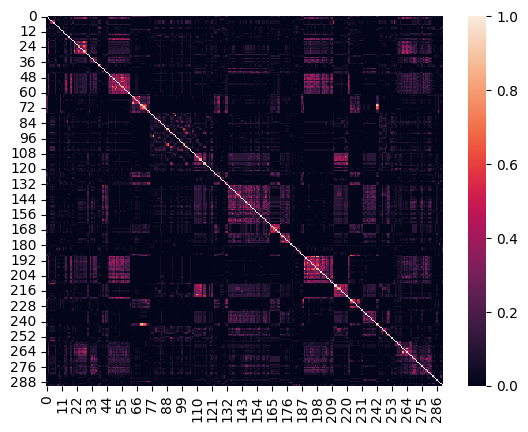

In [46]:
sns.heatmap(df_10)

In [61]:
df_11 = pd.DataFrame(df_10)
df_11

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
0,1.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.053,0.00,0.111,0.0,0.176,0.0,0.053,0.000
1,0.000,1.0,0.000,0.000,0.000,0.000,0.111,0.000,0.000,0.000,...,0.053,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.000
2,0.000,0.0,1.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,...,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.111
3,0.000,0.0,0.000,1.000,0.333,0.429,0.000,0.000,0.000,0.053,...,0.111,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.053
4,0.000,0.0,0.000,0.333,1.000,0.429,0.000,0.000,0.000,0.053,...,0.111,0.053,0.000,0.00,0.000,0.0,0.000,0.0,0.000,0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.00,0.000,1.0,0.000,0.0,0.000,0.000
287,0.176,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.053,0.00,0.053,0.0,1.000,0.0,0.053,0.000
288,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.00,0.000,0.0,0.000,1.0,0.000,0.000
289,0.053,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,...,0.053,0.053,0.250,0.25,0.000,0.0,0.053,0.0,1.000,0.000


In [62]:

drop_list = []
count = 0
print("drop list")
for i in range(len(df_11.columns)):
    score = 0
    
    for j in df_11.iloc[i]:
        score += j
    if score < 10:
        
        print("i : ", i, "  score : ", score)
        drop_list.append(count)
    else:
        pass
    count += 1
    
print(len(drop_list))

drop list
i :  0   score :  8.166
i :  2   score :  3.814999999999999
i :  6   score :  9.949000000000009
i :  7   score :  2.4889999999999985
i :  8   score :  2.7529999999999997
i :  9   score :  8.258999999999995
i :  10   score :  7.093999999999998
i :  11   score :  2.3829999999999987
i :  12   score :  4.540999999999999
i :  15   score :  7.9059999999999935
i :  16   score :  3.982
i :  19   score :  6.684999999999995
i :  21   score :  9.160000000000004
i :  31   score :  6.830999999999995
i :  37   score :  5.472999999999996
i :  38   score :  7.1749999999999945
i :  39   score :  8.858999999999998
i :  40   score :  1.5299999999999996
i :  42   score :  1.6939999999999993
i :  61   score :  5.801999999999999
i :  62   score :  6.875999999999995
i :  63   score :  9.846000000000009
i :  64   score :  8.864000000000003
i :  67   score :  8.431000000000004
i :  69   score :  8.838
i :  70   score :  9.652
i :  71   score :  9.453000000000001
i :  73   score :  8.875000000000005
i

In [63]:
print(drop_list)

[0, 2, 6, 7, 8, 9, 10, 11, 12, 15, 16, 19, 21, 31, 37, 38, 39, 40, 42, 61, 62, 63, 64, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 114, 117, 118, 119, 120, 122, 125, 126, 127, 128, 129, 130, 157, 168, 172, 174, 175, 179, 180, 181, 182, 183, 184, 185, 186, 187, 207, 225, 226, 227, 228, 229, 230, 231, 242, 243, 244, 245, 247, 249, 252, 253, 254, 257, 273, 283, 284, 285, 286, 287, 288, 289, 290]


In [64]:
df_11 = df_11.drop(drop_list, axis = 1)
df_11 = df_11.drop(drop_list, axis = 0)
display(df_11)

,1,3,4,5,13,14,17,18,20,22,...,272,274,275,276,277,278,279,280,281,282
1,1.000,0.000,0.000,0.000,0.053,0.111,0.176,0.176,0.333,0.250,...,0.176,0.111,0.053,0.176,0.053,0.250,0.176,0.111,0.053,0.053
3,0.000,1.000,0.333,0.429,0.053,0.000,0.053,0.000,0.000,0.000,...,0.176,0.053,0.000,0.000,0.053,0.053,0.000,0.111,0.111,0.053
4,0.000,0.333,1.000,0.429,0.053,0.000,0.000,0.000,0.000,0.000,...,0.111,0.053,0.000,0.000,0.111,0.053,0.000,0.111,0.111,0.053
5,0.000,0.429,0.429,1.000,0.053,0.000,0.053,0.000,0.000,0.000,...,0.111,0.053,0.000,0.000,0.053,0.053,0.000,0.111,0.111,0.053
13,0.053,0.053,0.053,0.053,1.000,0.053,0.053,0.053,0.053,0.053,...,0.111,0.053,0.111,0.053,0.111,0.053,0.053,0.176,0.176,0.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.250,0.053,0.053,0.053,0.053,0.111,0.111,0.176,0.111,0.111,...,0.176,0.176,0.053,0.250,0.053,1.000,0.429,0.250,0.111,0.053
279,0.176,0.000,0.000,0.000,0.053,0.176,0.111,0.176,0.111,0.111,...,0.111,0.176,0.111,0.333,0.053,0.429,1.000,0.176,0.111,0.111
280,0.111,0.111,0.111,0.111,0.176,0.111,0.111,0.111,0.111,0.111,...,0.111,0.250,0.176,0.176,0.250,0.250,0.176,1.000,0.333,0.176
281,0.053,0.111,0.111,0.111,0.176,0.111,0.111,0.111,0.053,0.053,...,0.111,0.250,0.333,0.176,0.250,0.111,0.111,0.333,1.000,0.250


<Axes: >

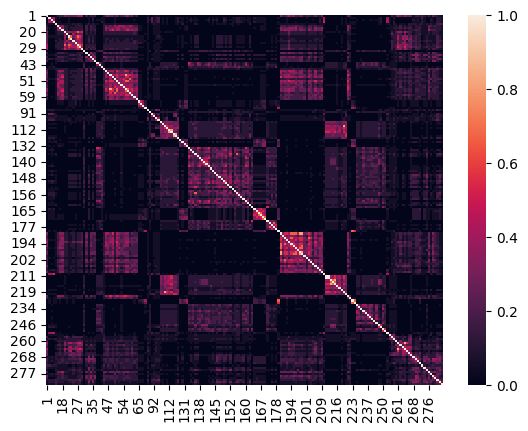

In [65]:
sns.heatmap(df_11)

In [66]:
for i in sorted(drop_list, reverse=True):
    column_title.remove(column_title[i])
    words_total_list.remove(words_total_list[i])
df_11 = df_11.mul(-1).add(1)

<Axes: >

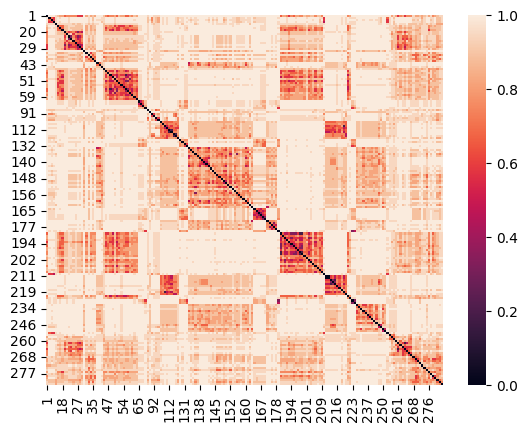

In [67]:
sns.heatmap(df_11)

In [68]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=3, linkage='average').fit(df_11)
print(model.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\jonghyun\anaconda3\envs\bmes\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [81]:
print("------------books cluster------------")
count =0

for i in model.labels_:
    if i == 0:
        print(column_title[count])
        
    count +=1



------------books cluster------------
ISBN--국방전자도서관 도서정보.
고시일자--건강보험심사평가원_의약품안전사용_병용금기_20230501.
고시일자--건강보험심사평가원_의약품안전사용_연령금기_20230501.
고시일자--건강보험심사평가원_의약품안전사용_임부금기_20220501.
단위--보건복지부 국립나주병원_비급여 수가 및 의약품 목록_20230227.
도 서 명--광주광역시_일가정양립지원본부_행복작은도서관 어린이도서 보유목록_20221024.
도서명--경상북도 안동시_시립도서관 도서 목록_20220901.
도서명--대전광역시 서구_둔산도서관 도서현황_20220906.
등록번호--경기도_용인시_도서대출 순위 정보_20190408..
등록번호--대전광역시 동구 도서관 보유도서 목록_20230110.
등록번호--대전광역시 서구_가수원도서관 도서현황_20221112 (1).
등록번호--대전광역시 서구_가수원도서관 도서현황_20221112.
등록번호--대전광역시 서구_월평도서관 도서현황_20230209.
등록번호--대전광역시 유성구_노은도서관 도서목록_20221027.
등록번호--대전광역시 유성구_유성도서관 도서목록_20220808.
등록번호--대전광역시 유성구_진잠도서관 도서목록_20221027.
등록번호--대전광역시_유성구_구즉도서관도서목록_20221027.
발행자--경기도_용인시_도서대출 순위 정보_20190408..
발행자--국방전자도서관 도서정보.
발행자--대구광역시교육청 대구광역시립서부도서관_신착도서목록_20230101.
발행자--서울특별시서대문구도시관리공단_구립도서관 도서정보_20200925.
발행처--서울도서관 새로 들어온 도서정보.
서가--대전광역시 서구_월평도서관 도서현황_20230209.
서명--경기도_용인시_도서대출 순위 정보_20190408..
서명--경상북도교육청 경상북도교육청상주도서관_추천도서 목록_20170201.
서명--기초과학연구원_과학문화센터_도서정보_20221001.
서명--대구광역시교육청 대구광역

In [84]:
print("------------foods cluster------------")
count =0

for i in model.labels_:
    if i == 1:
        print(column_title[count])
        
    count1 +=1


------------foods cluster------------
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
ISBN--국방전자도서관 도서정보.
IS

In [83]:
print("------------medicine cluster------------")
count =0

for i in model.labels_:
    if i == 2:
        print(column_title[count])
        
    count +=1


------------medicine cluster------------
성분명A--건강보험심사평가원_의약품안전사용_병용금기_20230501.
성분명B--건강보험심사평가원_의약품안전사용_병용금기_20230501.
성분영문명--보건복지부 국립나주병원_의약품 정보_20230227.
성분코드A--건강보험심사평가원_의약품안전사용_병용금기_20230501.
약품명칭--보건복지부 국립소록도병원_의약품정보_20220823.
약품분류--보건복지부 국립소록도병원_의약품정보_20220823.
약품한글명--보건복지부 국립공주병원_의약품 정보_20220927.
약품한글명--보건복지부 국립춘천병원_의약품목록_20221231.
업체명--건강보험심사평가원_약가마스터_급여의약품_20221001.
업체명--건강보험심사평가원_의약품안전사용_연령금기_20230501.
업체명--건강보험심사평가원_의약품안전사용_임부금기_20220501.
업체명--건강보험심사평가원_의약품유통_생산수입공급중단 보고대상 의약품 정보_20191231.
업체명A--건강보험심사평가원_의약품안전사용_병용금기_20230501.
업체명B--건강보험심사평가원_의약품안전사용_병용금기_20230501.
일반명코드--건강보험심사평가원_약가마스터_의약품주성분_20221001.
제품명--건강보험심사평가원_약가마스터_급여의약품_20221001.
제품명--건강보험심사평가원_의약품안전사용_연령금기_20230501.
17


# 새로운 파일 입력시 어떤 클러스터인지 알려주는 코드

In [45]:
prepared_colum_title = []
prepared_total_list = []

for file in os.listdir("raw_data/test_100"):
    with open("raw_data/test_100/" + file, "r", encoding = "utf-8") as f:
        json_obj = json.load(f)
    words_list = []
    
    prepared_colum_title.append(file[:-4])
    for i in json_obj[0][:10]:
        for j in range(int(i[1])):
            words_list.append(i[0])
    prepared_total_list.append(words_list)

In [48]:
count = 0
for i in prepared_total_list:
    if len(i) == 0:
        del prepared_total_list[count]
        del prepared_colum_title[count]
    count += 1
len(prepared_total_list)

291

In [49]:
count = 0
for i in prepared_total_list:
    if len(i) == 0:
        print(count)
    count += 1

In [56]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

count = 1

file_directory = "raw_data/new_tables"
category = "undefined"

for file in os.listdir(file_directory):
    print("Table #", count)
    print(file, "  테이블을 분석합니다")
    #불러오기
    
    try:
        df = pd.read_csv(file_directory+'/' + file, encoding = "utf-8", low_memory = False)
    except:
        pass
        
    try:
        df = pd.read_csv(file_directory+'/' + file, encoding = "cp949", low_memory = False)
    except:
        print("encoding error")
        continue

    print("Original Table")
    display(df)
    
    df = df.dropna(axis=1, thresh = 10)
    df = df.dropna(axis=0)
    
    if df.empty:
        print("Error : not enough catagorical data to sort")
        continue
    
    df = remove_int(df)
    df = remove_ununique(df)
    
    # 숫자가 하나라도 들어가면 삭제
    #df = remove_digit_str(df)
    print("Processed Table")
    display(df)
    
    if df.empty:
        continue
    
    for col in range(df.shape[1]):
        
        file_name_new = str(df.columns[col]) + "--" + file[:-4]
        
        print(file_name_new, " 을/를 분석합니다")
        
        result = []
        column_title = []
        words_total_list = []
        
        #여기서 i 는 몇번 검색할지 결정함
        for i in range(10):
                
            random_list = []
                
            # 여기서 j 는 몇개의 단어를 검색할지 결정함
            for j in range(10):
                random_row = random.randint(0,df.shape[0]-1)
                
                random_list.append(df.iloc[random_row, col])
                
            noun_list = search_and_return_occurence(random_list,100)
            
            #print(random_list)
            
            #print(noun_list)
            result.append(noun_list)
        #print(result)
        keywords_list = [return_significant_words(result, 10), [category,file[:-4],str(df.columns[col])]]
        
        
        print("KEYWORDS")
        print(keywords_list[0])
        
        
        words_list_new = []
        column_title.append(file_name_new)
        for i in keywords_list[0]:
            for j in range(int(i[1])):
                words_list_new.append(i[0])
        words_total_list.append(words_list_new)
        
        for i in prepared_total_list:
            words_total_list.append(i)
        for i in prepared_colum_title:
            column_title.append(prepared_colum_title)
        
        
        
        inputs = product(words_total_list, words_total_list)

        result = list(starmap(jaccard_similarity, inputs))
        
        group_result = list(group_(result, len(words_total_list)))
        df_10 = pd.DataFrame(group_result)
        
        df_11 = pd.DataFrame(df_10)
        drop_list = []
        count_1 = 0
        for i in range(len(df_11.columns)):
            score = 0
            for j in df_11.iloc[i]:
                score += j
            if score < 10:
                #print("i : ", i, "  score : ", score)
                drop_list.append(count_1)
            else:
                #print(score)
                count_1 += 1
        
        if drop_list[0] == 0:
            print(file_name_new, "  은/는 대표속성이 아닙니다")
        else:
        
            df_11 = df_11.drop(drop_list, axis = 1)
            df_11 = df_11.drop(drop_list, axis = 0)
        
        
            for i in sorted(drop_list, reverse=True):
                column_title.remove(column_title[i])
                words_total_list.remove(words_total_list[i])
            
            df_11 = df_11.mul(-1).add(1)
        
            model = AgglomerativeClustering(affinity='precomputed', n_clusters=3, linkage='average').fit(df_11)
        
            if model.labels_[0] == 0:
                print(file_name_new, " 은/는 foods 카테고리에 속합니다")
            if model.labels_[0] == 1:
                print(file_name_new, " 은/는 books 카테고리에 속합니다")
            if model.labels_[0] == 2:
                print(file_name_new, " 은/는 medicine 카테고리에 속합니다")
            print("----------------------------------------------------------------------------------------------------------------")
    
    count +=1

Table # 1
대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1).csv   테이블을 분석합니다
Original Table


,순위,등록번호,서명,저자,발행자,청구기호,대출횟수
0,1,BGK000462045,(흔한 남매) 안 흔한 일기. 2,흔한남매 원작 ; 강효미 글 ; 조병주 그림,Mirae N 아이세움,J 813.8-흔91ㅇ-2,10
1,2,BGK000457259,(흔한 남매) 안 흔한 일기. 1,흔한남매 원작 ; 강효미 글 ; 조병주 그림,Mirae N 아이세움,J 813.8-흔91ㅇ-1,10
2,3,BGK000257217,클루지=Kluge : 생각의 역사를 뒤집는 기막힌 발견,개리 마커스 지음 ; 최호영 옮김,갤리온,182.4-마823ㅋ,9
3,4,BGK000477493,흔한남매. 8,원작: 흔한남매 ; 글: 백난도 ; 그림: 유난희,Mirae N 아이세움,J 813.8-흔91ㅎ-8,9
4,5,BGK000481182,흔한남매 흔한 MBTI : 믿거나 말거나 나에게 어울리는 직업,"흔한남매 원작 ; 김승자,정미화 글 ; 투윙스,유영근 그림",대원키즈,J 321.55-흔91ㅎ,9
...,...,...,...,...,...,...,...
195,196,BGK000494964,"(그림으로 보는) 삼국지. 1, 세 영웅의 등장",글: 스카이엠 ; 그림: 한철호,계림북스,J 823.5-스821ㅅ-1,6
196,197,BGK000499313,"태양의 마녀 나코와 코기 봉봉. 2, 의문의 라이벌이 등장하다.",히로시마 레이코 글 ; KeG 그림 ; 김정화 옮김,웅진주니어,J 833.8-히235ㅌ-2,6
197,198,BGK000500228,비밀의 숲 코끼리 나무 : 프레야 블랙우드 그림책,지은이: 프레야 블랙우드,M창비(미디어창비),MC 843-블232ㅂ,6
198,199,BGK000500389,부모의 돈 교육 : 돈을 다루는 능력을 가르치는 법,권유정 지음,미래문화사,327.04-권67ㅂ,6


Processed Table


,등록번호,서명,저자,발행자,청구기호
0,BGK000462045,(흔한 남매) 안 흔한 일기. 2,흔한남매 원작 ; 강효미 글 ; 조병주 그림,Mirae N 아이세움,J 813.8-흔91ㅇ-2
1,BGK000457259,(흔한 남매) 안 흔한 일기. 1,흔한남매 원작 ; 강효미 글 ; 조병주 그림,Mirae N 아이세움,J 813.8-흔91ㅇ-1
2,BGK000257217,클루지=Kluge : 생각의 역사를 뒤집는 기막힌 발견,개리 마커스 지음 ; 최호영 옮김,갤리온,182.4-마823ㅋ
3,BGK000477493,흔한남매. 8,원작: 흔한남매 ; 글: 백난도 ; 그림: 유난희,Mirae N 아이세움,J 813.8-흔91ㅎ-8
4,BGK000481182,흔한남매 흔한 MBTI : 믿거나 말거나 나에게 어울리는 직업,"흔한남매 원작 ; 김승자,정미화 글 ; 투윙스,유영근 그림",대원키즈,J 321.55-흔91ㅎ
...,...,...,...,...,...
195,BGK000494964,"(그림으로 보는) 삼국지. 1, 세 영웅의 등장",글: 스카이엠 ; 그림: 한철호,계림북스,J 823.5-스821ㅅ-1
196,BGK000499313,"태양의 마녀 나코와 코기 봉봉. 2, 의문의 라이벌이 등장하다.",히로시마 레이코 글 ; KeG 그림 ; 김정화 옮김,웅진주니어,J 833.8-히235ㅌ-2
197,BGK000500228,비밀의 숲 코끼리 나무 : 프레야 블랙우드 그림책,지은이: 프레야 블랙우드,M창비(미디어창비),MC 843-블232ㅂ
198,BGK000500389,부모의 돈 교육 : 돈을 다루는 능력을 가르치는 법,권유정 지음,미래문화사,327.04-권67ㅂ


등록번호--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)  을/를 분석합니다
KEYWORDS
[('대출', 4), ('동부', 4), ('기호', 4), ('대구광역시', 4), ('도서관', 4), ('표준', 4), ('부호', 4), ('분류', 4), ('한국', 4), ('십진분류법', 4)]
등록번호--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)   은/는 대표속성이 아닙니다
서명--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)  을/를 분석합니다
KEYWORDS
[('도서', 10), ('사항', 8), ('도서관', 7), ('저자', 6), ('세트', 5), ('상세', 4), ('스토리', 4), ('그림', 3), ('유튜브', 3), ('중고', 3)]
서명--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)  은/는 books 카테고리에 속합니다
----------------------------------------------------------------------------------------------------------------
저자--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)  을/를 분석합니다
KEYWORDS
[('그림', 9), ('도서관', 9), ('원작', 7), ('학습만화', 5), ('발행', 5), ('선택', 5), ('남매', 4), ('스토리', 4), ('저자', 4), ('페이지', 4)]
저자--대구광역시교육청 대구광역시립동부도서관_인기도서 목록_20230331 (1)  은/는 books 카테고리에 속합니다
----------------------------------------------------------------------------------------------------------------
발행자--대구광역시교육청 대구광역시립동부도서

,특성별(1),특성별(2),지하철 매우 불만족 (퍼센트),지하철 약간 불만족 (퍼센트),지하철 보통 (퍼센트),지하철 약간 만족 (퍼센트),지하철 매우 만족 (퍼센트),지하철 5점 평균 (점)
0,군구별,중구,3.2,15.7,28.1,43.9,9.1,3.4
1,군구별,동구,6.7,9.5,36.4,31.9,15.4,3.4
2,군구별,미추홀구,0.7,3.2,53.7,29.4,13.0,3.5
3,군구별,연수구,5.3,5.5,29.3,37.6,22.3,3.7
4,군구별,남동구,1.1,8.8,36.1,31.1,22.9,3.7
5,군구별,부평구,2.0,4.6,32.5,37.1,23.8,3.8
6,군구별,계양구,1.1,4.3,17.2,42.8,34.6,4.1
7,군구별,서구,10.1,8.5,28.0,33.1,20.4,3.5
8,군구별,강화군,32.1,1.6,38.5,7.9,19.9,2.8
9,군구별,옹진군,4.1,14.5,28.9,22.6,29.9,3.6


Processed Table


,특성별(2)
0,중구
1,동구
2,미추홀구
3,연수구
4,남동구
5,부평구
6,계양구
7,서구
8,강화군
9,옹진군


특성별(2)--인천광역시_대중교통 이용 만족도 지하철_20211231  을/를 분석합니다
KEYWORDS
[('대출', 7), ('개인', 5), ('이상', 5), ('주택', 4), ('중졸', 4), ('회생', 4), ('검정고시', 4), ('과학', 4), ('문제', 4), ('기출', 4)]
특성별(2)--인천광역시_대중교통 이용 만족도 지하철_20211231   은/는 대표속성이 아닙니다
